In [1]:
'''
URJC / GIA / Aprendizaje Automático 1 / Curso 23-24
alfredo.cuesta@urjc.es
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, confusion_matrix

plt.rcParams['figure.figsize']=(4,4)
np.set_printoptions(precision=2)
pd.set_option("display.precision", 4)
seed = 1460

# Ejemplo

Utilizando el conjunto de datos **california_housing**, que está en la carpeta *sample_data* de todo Google Colab queremos estimar si los ingresos de esa zona (en mediana) serán superiores o inferiores a 3.5 con un SVM.

## Creación del sistema clasificador

1. Cargamos el conjunto de datos de entrenamiento

In [2]:
#- cargar data set
folder_name = 'sample_data/'
file_name = 'california_housing_train.csv'
trainSet = pd.read_csv(folder_name+file_name)
target = ['median_income']
train_target = trainSet[target]
trainSet.drop(target, axis=1, inplace=True)
features = trainSet.columns

\2. Obtenemos la etiqueta a partir de la columna "_median_income_"

In [3]:
train_target = (train_target > 3.5)*1 #El *1 es pa q convierta los booleanos en 0 y 1

3. Separamos el conjunto de entrenamiento en dos para poder evaluar el modelo
  - Entrenamiento = 80%
  - Validación = 20%

In [4]:
val_size = 0.2

X_train, X_val, Y_train, Y_val = train_test_split(trainSet, train_target,
                                                  test_size=val_size,
                                              stratify=train_target,
                                                  shuffle=True,
                                              random_state=seed)

4. Con SVM conviene tener las características escaladas al intervalo $[0,1]$ o al $[-1,1]$.

  En este caso vamos a utilizar "_MaxAbsScaler_"
  

En este ejemplo NO vamos a hacer ningún otro preprocesado. SIEMPRE MAX ABS


In [ ]:
scaler = MaxAbsScaler().set_output(transform='pandas')

scaler.fit(X_train)
X_train_scl = scaler.transform(X_train)

5. Entrenar un modelo SVM para clasificación; es decir SVC.
Modificamos la celda de abajo para obtener un modelo mejor:



In [14]:
max_iter = 2**12  #<- cambiando el exponente duplicamos
C_svc = 2**4    #<- lo mismo #Modificamos esto, que es lo que modifica "la importancia que tienen" las variables slack
kernel = 'rbf' #<- linear, rbf, poly, ... ver documentación
d=2

svc_model_linear = SVC(kernel='linear', C = 2**5, degree=d, max_iter=max_iter)
svc_model_linear.fit(X_train_scl, Y_train.values.ravel())

svc_model_rbf = SVC(kernel='rbf', C = C_svc, degree=d, max_iter=max_iter)
svc_model_rbf.fit(X_train_scl, Y_train.values.ravel())


svc_model_poly = SVC(kernel='poly', C = C_svc, degree=d, max_iter=max_iter)
svc_model_poly.fit(X_train_scl, Y_train.values.ravel())

#- SVM de Scikit-Learn no trabaja bien con Pandas.
#  Se le puede pasar Y_train pero devuelve mensajes de aviso ('warnings')
#  Por eso se extran los valores y se convierten en un array de un solo eje.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4096).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4096).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=4096).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVC(C=16, degree=2, kernel='poly', max_iter=4096)

6. Una vez aprendido el modelo, vemos que tal funciona con el conjunto de validación; que son ejemplos que NUNCA ha visto el modelo, igual que ocurrirá con el conjunto de test.

In [15]:
X_val_scl = scaler.transform(X_val)
y_pred_linear = svc_model_linear.predict(X_val_scl)

# Calcular la precisión
accuracy = accuracy_score(Y_val, y_pred_linear)
# Calcular la matriz de confusión
cf_mat_linear = confusion_matrix(Y_val, y_pred_linear)

print(f'accuracy kernel lineal= {accuracy:0.3f}\n')
print(f'Matriz de confusion kernel lineal= \n {pd.DataFrame(cf_mat_linear)}')

X_val_scl = scaler.transform(X_val)
y_pred_rbf = svc_model_rbf.predict(X_val_scl)

# Calcular la precisión
accuracy = accuracy_score(Y_val, y_pred_rbf)
# Calcular la matriz de confusión
cf_mat = confusion_matrix(Y_val, y_pred_rbf)

print(f'accuracy kernel rbf = {accuracy:0.3f}\n')
print(f'Matriz de confusion kernel rbf= \n {pd.DataFrame(cf_mat)}')

y_pred_poly = svc_model_poly.predict(X_val_scl)

# Calcular la precisión
accuracy = accuracy_score(Y_val, y_pred_poly)
# Calcular la matriz de confusión
cf_mat = confusion_matrix(Y_val, y_pred_poly)

print(f'accuracy kernel poly = {accuracy:0.3f}\n')
print(f'Matriz de confusion kernel poly= \n {pd.DataFrame(cf_mat)}')

accuracy kernel lineal= 0.847

Matriz de confusion kernel lineal= 
       0     1
0  1354   305
1   214  1527
accuracy kernel rbf = 0.851

Matriz de confusion kernel rbf= 
       0     1
0  1396   263
1   243  1498
accuracy kernel poly = 0.846

Matriz de confusion kernel poly= 
       0     1
0  1373   286
1   239  1502


7. Hemos obtenido un 84% de _accuracy_. No está mal :)

  Vamos a ver el modelo

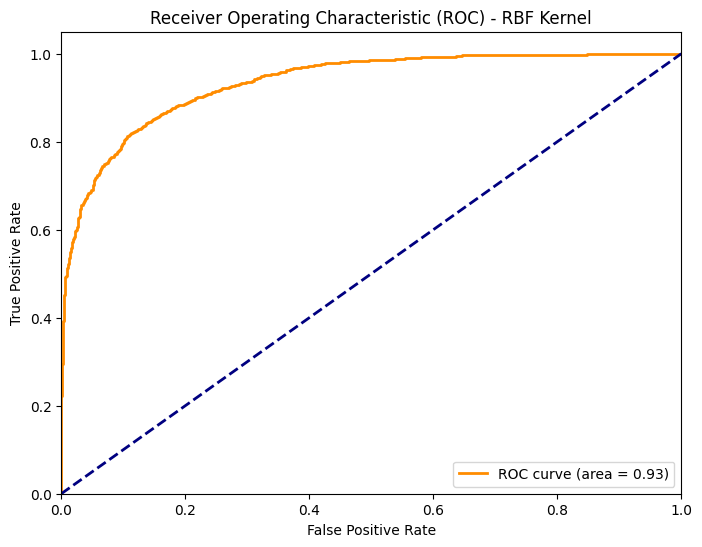

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Para SVC, utilizamos decision_function para obtener las "distancias" a la frontera de decisión
y_score_rbf = svc_model_rbf.decision_function(X_val_scl)

# Calcular FPR, TPR, y umbrales para la curva ROC
fpr_rbf, tpr_rbf, _ = roc_curve(Y_val, y_score_rbf)

# Calcular el AUC
roc_auc_rbf = auc(fpr_rbf, tpr_rbf)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rbf, tpr_rbf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rbf:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - RBF Kernel')
plt.legend(loc="lower right")
plt.show()


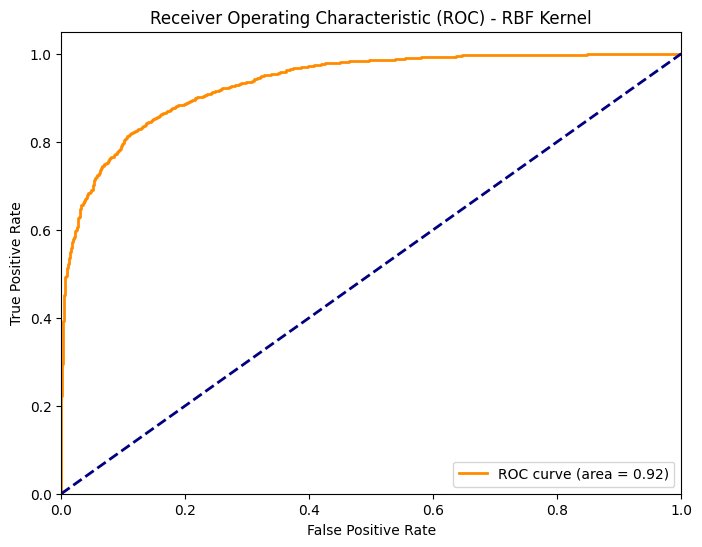

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Para SVC, utilizamos decision_function para obtener las "distancias" a la frontera de decisión
y_score_linear = svc_model_linear.decision_function(X_val_scl)

# Calcular FPR, TPR, y umbrales para la curva ROC
fpr_linear, tpr_linear, _ = roc_curve(Y_val, y_score_linear)

# Calcular el AUC
roc_auc_linear = auc(fpr_linear, tpr_linear)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rbf, tpr_rbf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_linear:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Kernel Lineal')
plt.legend(loc="lower right")
plt.show()


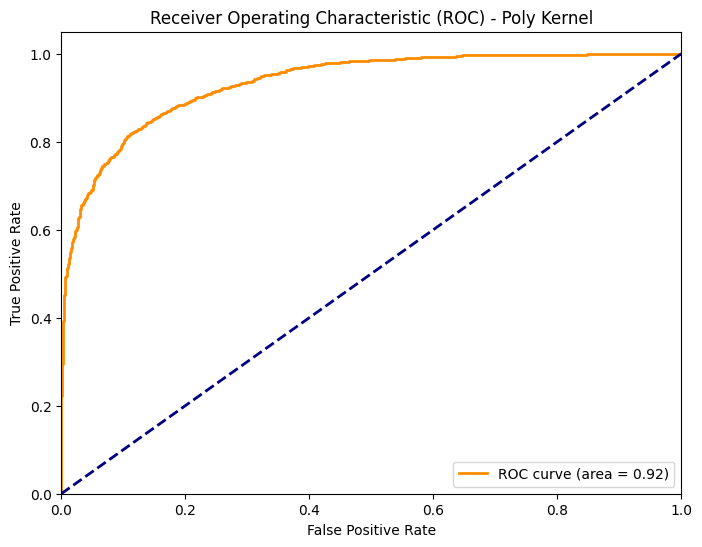

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Para SVC, utilizamos decision_function para obtener las "distancias" a la frontera de decisión
y_score_poly = svc_model_poly.decision_function(X_val_scl)

# Calcular FPR, TPR, y umbrales para la curva ROC
fpr_poly, tpr_poly, _ = roc_curve(Y_val, y_score_poly)

# Calcular el AUC
roc_auc_poly = auc(fpr_poly, tpr_poly)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_rbf, tpr_rbf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_linear:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Poly Kernel')
plt.legend(loc="lower right")
plt.show()


In [10]:
svc_model_linear.__dict__
#En support vemos los "arrays" que indica las filas de las tablas de X_train que son los que soportan esta máquina.

{'decision_function_shape': 'ovr',
 'break_ties': False,
 'kernel': 'linear',
 'degree': 2,
 'gamma': 'scale',
 'coef0': 0.0,
 'tol': 0.001,
 'C': 16,
 'nu': 0.0,
 'epsilon': 0.0,
 'shrinking': True,
 'probability': False,
 'cache_size': 200,
 'class_weight': None,
 'verbose': False,
 'max_iter': 4096,
 'random_state': None,
 '_sparse': False,
 'feature_names_in_': array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
        'total_bedrooms', 'population', 'households', 'median_house_value'],
       dtype=object),
 'n_features_in_': 8,
 'class_weight_': array([1., 1.]),
 'classes_': array([0, 1]),
 '_gamma': 0.4743481363605758,
 'support_': array([    3,     4,    11, ..., 13594, 13598, 13599], dtype=int32),
 'support_vectors_': array([[-0.95,  0.81,  0.83, ...,  0.02,  0.05,  0.28],
        [-0.95,  0.81,  1.  , ...,  0.01,  0.02,  0.27],
        [-0.95,  0.8 ,  0.38, ...,  0.02,  0.06,  0.44],
        ...,
        [-0.98,  0.92,  0.65, ...,  0.03,  0.08,  0.33],
     

## Inferencia con el sistema clasificador

- ¿Qué pasaría si desplegamos este sistema en el destino? <br>
Le llegarán ejemplos nuevos y hará estimaciones de su etiqueta.

- ¿Qué tal funcionaría?<br>
Por "suerte" el conjunto de test tiene etiquetas (lo que no pasará cuando de verdad lo pongamos en funcionamiento).

Vamos a cargar el conjunto de test y ver qué tal funciona con nuestro sistema.

In [ ]:
#- cargar conjunto de test
folder_name = 'sample_data/'
file_name = 'california_housing_test.csv'
X_test = pd.read_csv(folder_name+file_name)
target = ['median_income']
Y_test = X_test[target]
X_test.drop(target, axis=1, inplace=True)
features = X_test.columns

#- convertir la etiqueta a 0 y 1
Y_test = (Y_test > 3.5)*1

#- alimentar los datos al sistema
X_test_scl = scaler.transform(X_test)
y_hat = svc_model.predict(X_test_scl)

#- Calcular la precisión
accuracy = accuracy_score(Y_test, y_hat)
#- Calcular la matriz de confusión
cf_mat = confusion_matrix(Y_test, y_hat)

print(f'accuracy = {accuracy:0.3f}\n')
print(f'Matriz de confusion = \n {pd.DataFrame(cf_mat)}')

# Ejercicios

1. Leer la documentaciòn de SVC y modificar el paso 6 para probar otros modelos


con otras opciones; por ejemplo otros kernel, diferentes hiperparámetros, etc.

2. Probar varios modelos y luego dibujar sus curvas ROC.

  ¿Qué modelo es mejor según el área bajo la ROC (AUROC) ?

3. Hacer una visualización del conjunto de entrenamiento y el clasificador utilizado. Para ello conviene utilizar PCA por lo que tendrás que repetir el código añadiendo PCA en el preprocesado.

  Recuerda que para crear la imagen hay que hacer un barrido del intervalo que vayas a mostrar. En este caso el plano será (pca0, pca1).